In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import nearest_points
import branca.colormap as cm
from sklearn.model_selection import RandomizedSearchCV
import joblib
import osm_functions as osf


from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Workaround to fix chrome issue where folium won't plot maps with a large number of layers
# See comment by dstein64 at: https://github.com/python-visualization/folium/issues/812

import base64
def _repr_html_(self, **kwargs):
    html = base64.b64encode(self.render(**kwargs).encode('utf8')).decode('utf8')
    onload = (
        'this.contentDocument.open();'
        'this.contentDocument.write(atob(this.getAttribute(\'data-html\')));'
        'this.contentDocument.close();'
    )
    if self.height is None:
        iframe = (
            '<div style="width:{width};">'
            '<div style="position:relative;width:100%;height:0;padding-bottom:{ratio};">'
            '<iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;'
            'border:none !important;" '
            'data-html={html} onload="{onload}" '
            'allowfullscreen webkitallowfullscreen mozallowfullscreen>'
            '</iframe>'
            '</div></div>').format
        iframe = iframe(html=html, onload=onload, width=self.width, ratio=self.ratio)
    else:
        iframe = ('<iframe src="about:blank" width="{width}" height="{height}"'
                  'style="border:none !important;" '
                  'data-html={html} onload="{onload}" '
                  '"allowfullscreen" "webkitallowfullscreen" "mozallowfullscreen">'
                  '</iframe>').format
        iframe = iframe(html=html, onload=onload, width=self.width, height=self.height)
    return iframe

folium.branca.element.Figure._repr_html_ = _repr_html_


In [3]:
# load and combine data
folder_name = 'OSM_geo_data/'
city_names = ['austin','berkeley','boston','chicago','denver','glasgow','los_angeles',
              'minneapolis','montreal','new_york','san_francisco','salt_lake_city','phoenix',
             'columbus','paris','munich','brussels']


# Initialize dataframes
df = pd.DataFrame()
city_grid = pd.DataFrame()

# Combine data from different cities
for name in city_names:
    filename_cleaned_df = folder_name + name + '_feature_target_table.geojson'
    filename_grid = folder_name + name + '_grid.geojson'
    if df.empty:
        df = gpd.read_file(filename_cleaned_df)
        city_grid = gpd.read_file(filename_grid)
    else:
        df = df.append(gpd.read_file(filename_cleaned_df), ignore_index=True)





In [4]:
# Define feature and target labels
features = ['pharmacy_density', 'recycling_density', 'place_of_worship_density', 'post_box_density',
            'library_density', 'post_office_density', 'parking_density', 'fuel_density', 'bank_density',
            'pub_density', 'telephone_density', 'toilets_density', 'taxi_density', 'bicycle_parking_density',
            'motorcycle_parking_density', 'fast_food_density', 'bar_density', 'life_boats_density',
            'restaurant_density', 'arts_centre_density', 'music_venue_density', 'nightclub_density',
            'cafe_density', 'atm_density', 'community_centre_density', 'jobcentre_density', 'doctors_density',
            'cinema_density', 'grave_yard_density', 'police_density', 'bus_station_density', 'theatre_density',
            'bureau_de_change_density', 'hospital_density', 'bench_density', 'school_density', 'courthouse_density',
            'ice_cream_density', 'fountain_density', 'left_luggage_density', 'drinking_water_density',
            'casino_density', 'car_rental_density', 'car_wash_density', 'ferry_terminal_density', 'dentist_density',
            'townhall_density', 'shelter_density', 'parking_entrance_density', 'conference_centre_density',
            'marketplace_density', 'vending_machine_density', 'waste_basket_density', 'clock_density',
            'studio_density', 'veterinary_density', 'gallery_density', 'gambling_density', 'kindergarten_density',
            'social_facility_density', 'charging_station_density', 'car_sharing_density', 'clinic_density',
            'water_density', 'compressed_air_density', 'public_building_density', 'social_centre_density',
            'childcare_density', 'grit_bin_density', 'bicycle_repair_station_density', 'events_venue_density',
            'embassy_density', 'college_density', 'circus_school_density', 'parcel_lockers_density',
            'money_transfer_density', 'photo_booth_density', 'luggage_locker_density', 'university_density',
            'venue_density', 'swimming_pool_density', 'fire_station_density', 'post_depot_density',
            'crematorium_density', 'sport_density', 'nursing_home_density', 'biergarten_density', 'garden_density',
            'prison_density', 'club_density', 'parking_space_density', 'trailer_park_density', 'archive_density',
            'monastery_density']
target = ['bike_rental_density']

In [5]:
## Remove features that are very sparse
# Get percentage of non-zero values for target variable
pcent_target_positive = df[target].astype(bool).sum(axis=0)/len(df)

# Get percentage of non zero values for each feature
pcent_non_zero_features = df[features].astype(bool).sum(axis=0)/len(df)

# Get features that are not sparse
zero_pcent_threshold = 0.01
relevant_features = pcent_non_zero_features.index[pcent_non_zero_features>zero_pcent_threshold].tolist()



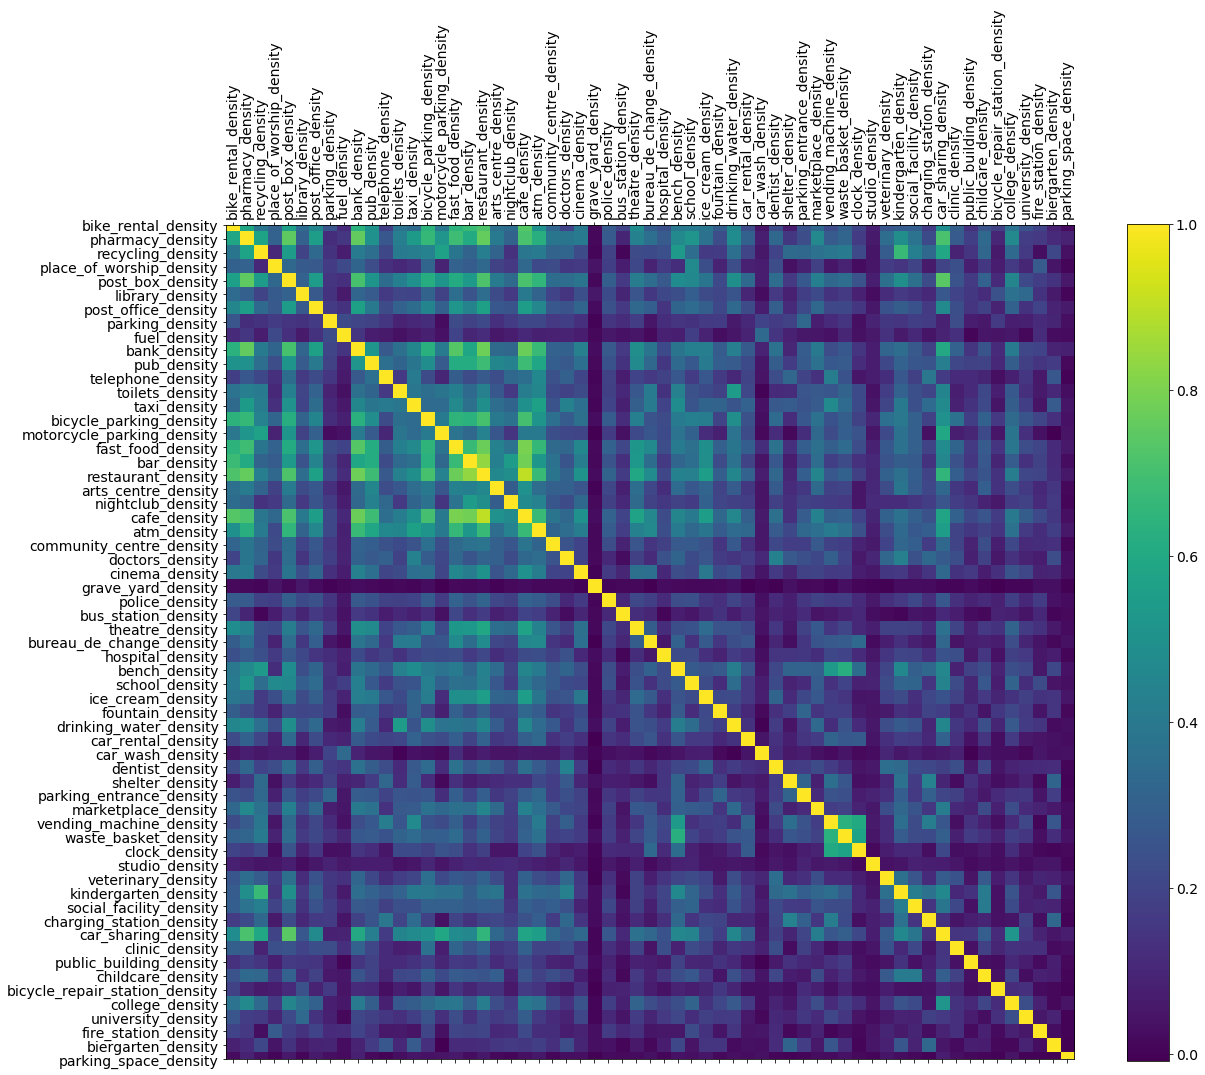

In [6]:
## Show correlation between input features
corr_df = df[target + relevant_features].corr()

f = plt.figure(figsize=(19, 15))
plt.matshow(corr_df, fignum=f.number)
plt.xticks(range(corr_df.shape[1]), corr_df.columns, fontsize=14, rotation=90)
plt.yticks(range(corr_df.shape[1]), corr_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)


In [7]:
# Remove features that are below the correlation threshold
corr_threshold = 0.2
feature_relevance = (corr_df.bike_rental_density).sort_values(ascending=False)
feature_relevance
top_features = list(feature_relevance[feature_relevance > corr_threshold].index)

# make sure to remove bike_rentals from training data 
top_features.remove('bike_rental_density')
# remove features that are strongly correlated to others
top_features.remove('post_box_density') # correlated to car shares
top_features.remove('restaurant_density') # correlated to cafes

top_features = top_features[:35]
# Keep only the top 3 features
print(top_features)
print('Number of features reduced to %2.0f from %2.0f' % (len(top_features), len(features)))

['cafe_density', 'bar_density', 'bicycle_parking_density', 'fast_food_density', 'bank_density', 'pharmacy_density', 'pub_density', 'atm_density', 'car_sharing_density', 'theatre_density', 'post_office_density', 'drinking_water_density', 'school_density', 'cinema_density', 'bench_density', 'motorcycle_parking_density', 'ice_cream_density', 'recycling_density', 'college_density', 'toilets_density', 'arts_centre_density', 'nightclub_density', 'library_density', 'taxi_density', 'marketplace_density', 'community_centre_density', 'place_of_worship_density', 'waste_basket_density', 'clinic_density', 'social_facility_density', 'fountain_density', 'bureau_de_change_density', 'kindergarten_density', 'police_density', 'veterinary_density']
Number of features reduced to 35 from 94


In [8]:
# Profile features collected from OSM and check for correlation
# feature_profile = pandas_profiling.ProfileReport(df[target + features])
# feature_profile.to_file(output_file='osm_bike_share_feature_profile.html')


956 7991 0.1196345889125266
Linear regression is not the best option given that the target is highly skewed towards 0


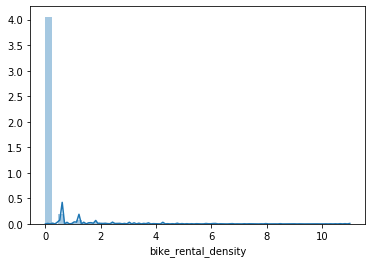

In [9]:
# Split data into train and test
X = df[top_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pos_target = len(y[y.bike_rental_density != 0])
neg_target = len(y[y.bike_rental_density == 0])
print(pos_target,neg_target,pos_target/neg_target)

sns.distplot(y.bike_rental_density);
print('Linear regression is not the best option given that the target is highly skewed towards 0')

In [10]:
## Linear model
LM_model = LinearRegression()
LM_model.fit(X_train,y_train)
LM_y_pred = LM_model.predict(X_test)

## Lasso
lasso_rmse = []
ridge_rmse = []
EN_rmse = []
alpha_ref = np.linspace(0.001,1,101)

for ind, alpha in enumerate(alpha_ref):
    
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train,y_train)
    lasso_y_pred = lasso_model.predict(X_test)
    lasso_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))
    
    
    ridge_model = Ridge(alpha = alpha)
    ridge_model.fit(X_train,y_train)
    ridge_y_pred = ridge_model.predict(X_test)
    ridge_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))
    
    EN_model = ElasticNet(alpha = alpha)
    EN_model.fit(X_train,y_train)
    EN_y_pred = EN_model.predict(X_test)
    EN_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))


## Random Forest
# RF_model = RandomForestRegressor(random_state = 2,max_depth = 9,max_leaf_nodes = 67)
RF_model = RandomForestRegressor(max_depth = 10)
RF_model.fit(X_train,y_train)
RF_y_pred = RF_model.predict(X_test)

print('Multivariate linear regression mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(y_test,LM_y_pred))
print('Lasso mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(lasso_rmse),alpha_ref[np.argmin(lasso_rmse)]))
print('Ridge mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(ridge_rmse),alpha_ref[np.argmin(ridge_rmse)]))
print('Elastic Net mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(EN_rmse),alpha_ref[np.argmin(EN_rmse)]))

print('Random forest mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(y_test,RF_y_pred))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Multivariate linear regression mean absolute error (MAE): 0.171
Lasso mean absolute error (MAE): 0.170 and alpha = 0.001
Ridge mean absolute error (MAE): 0.170 and alpha = 0.001
Elastic Net mean absolute error (MAE): 0.170 and alpha = 0.001
Random forest mean absolute error (MAE): 0.154


# Random Forest Tuning

In [11]:
## Define random grid for tuning random forest parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
## Use the random grid to search for best RF hyperparameters
# Takes a long time, only run if you have time

# First create the base model to tune
rf2 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.8min


In [ ]:
## Predict bike shares using the best RF 
best_random = rf_random.best_estimator_
RF_rand_y_pred = best_random.predict(X_test)

print('Best Random forest mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(y_test,RF_rand_y_pred))

# dat = {'features': top_features,'coefficient': best_random.feature_importances_}
# ft_importance = pd.DataFrame(dat)
# ft_importance = ft_importance.sort_values(by='coefficient', ascending = False)
# ft_importance

In [ ]:
# Save best RF model
# save the model to disk
filename = 'best_RF_model.sav'
joblib.dump(best_random, filename)

# Independent model prediction on Portland

Portland is not included in the training set and this is used for independent validation

In [ ]:
## Start validation on unseen city, 
place = 'Portland, Oregon, USA'

# city_grid = gpd.read_file(filename_grid)
# all_amenities = gpd.read_file(filename_amenities)
# bike_rentals = gpd.read_file(filename_bike_rentals)

# Generate city grid for interrogation
city = ox.gdf_from_place(place)
portland_grid = gpd.read_file(folder_name + 'portland_grid.geojson')
portland_ft = gpd.read_file(folder_name + 'portland_feature_target_table.geojson')
portland_bike_rentals = gpd.read_file(folder_name + 'portland_bike_rentals.geojson')

In [ ]:
portland_predict = RF_model.predict(portland_ft[top_features])
portland_comparison = portland_grid.copy()
portland_comparison['bike_rental_density'] = portland_ft['bike_rental_density'] 
portland_comparison['RF_prediction'] = portland_predict
portland_comparison['bike_rental_diff'] = portland_comparison['RF_prediction'] - portland_comparison['bike_rental_density']

scale_factor = max(max(portland_predict),max(portland_comparison.bike_rental_density))

portland_comparison['scaled_actual_density'] = portland_ft['bike_rental_density'] / scale_factor
portland_comparison['scaled_pred_density'] = portland_comparison['RF_prediction'] / scale_factor

print('Random forest mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(portland_comparison.bike_rental_density,portland_comparison.RF_prediction))
print('Random forest mean squared error (MSE): %4.3f' % metrics.mean_squared_error(portland_comparison.bike_rental_density,portland_comparison.RF_prediction))
print('Random forest root mean squared error (RMSE): %4.3f' % np.sqrt(metrics.mean_squared_error(portland_comparison.bike_rental_density,portland_comparison.RF_prediction)))


# RMSE is low because most of the grid cells are empty and random forest captures that well. Does this misrepresent the accuracty?
# Results could be improved with bike friendliness score

In [ ]:
# define dictionaries for opacity and colormaps
pred_dict = portland_comparison['scaled_pred_density']
actual_dict = portland_comparison['scaled_actual_density']
diff_dict = portland_comparison['bike_rental_diff']

pred_opacity = {str(key): pred_dict[key] for key in pred_dict.keys()}
actual_opacity = {str(key): actual_dict[key] for key in actual_dict.keys()}
diff_opacity = {str(key): abs(diff_dict[key]) for key in diff_dict.keys()}

colormap = cm.linear.RdBu_11.scale(-scale_factor,scale_factor)
# colormap = cm.LinearColormap(colors=['yellow','white','green'],vmin=0,vmax=scale_factor)

diff_color = {str(key): colormap(diff_dict[key]) for key in diff_dict.keys()}
colormap

In [ ]:
m = folium.Map([city.geometry.centroid.y, city.geometry.centroid.x],
               zoom_start=11,
               tiles="CartoDb positron")

style_city = {'color':'#ebc923 ', 'fillColor': '#ebc923 ', 'weight':'1', 'fillOpacity' : 0.1}
folium.GeoJson(city,
               style_function=lambda x: style_city,
               name='City Limit').add_to(m)

# Plot actual bike share density
folium.GeoJson(
    portland_comparison['geometry'],
    name='Actual bike share density',
    style_function=lambda feature: {
        'fillColor': '#0675c4',
        'color': 'black',
        'weight': 0,
        'fillOpacity': actual_opacity[feature['id']],
    }
).add_to(m)

# plot predictions of bike share density
folium.GeoJson(
    portland_comparison['geometry'],
    name='Prediction: bike share density',
    style_function=lambda feature: {
        'fillColor': '#0675c4',
        'color': 'black',
        'weight': 0,
        'fillOpacity': pred_opacity[feature['id']],
    }
).add_to(m)

# plot difference between predicted and actual
# folium.GeoJson(
#     portland_comparison['geometry'],
#     name='Difference: bike share density',
#     style_function=lambda feature: {
#         'fillColor': '#1FFD09',
#         'color': 'black',
#         'weight': 0,
#         'fillOpacity': diff_opacity[feature['id']],
#     }
# ).add_to(m)

folium.GeoJson(
    portland_comparison['geometry'],
    name='Difference: bike share density',
    style_function=lambda feature: {
        'fillColor': diff_color[feature['id']],
        'color': 'black',
        'weight': 0,
#         'fillOpacity': 0.5,
        'fillOpacity': diff_opacity[feature['id']],
    }
).add_to(m)

colormap.caption = 'Difference in bike density prediction'
colormap.add_to(m)


folium.LayerControl().add_to(m)

# m.save("portland_validation.html")
m

In [ ]:
## Tried to put into categories and compute confusion matrix but prediction is of bike share demand and not categories

# positives = portland_comparison[(portland_comparison.bike_rental_density != 0)]
# negatives = portland_comparison[(portland_comparison.bike_rental_density == 0)]
# pos_count = len(positives)
# neg_count = len(negatives)

# print('Positives %2.0f, Negatives %2.0f, Total %2.0f' % (pos_count,neg_count,len(portland_comparison)))

# density_threshold = 0
# true_pos = portland_comparison[(portland_comparison.bike_rental_density != 0) & (portland_comparison.bike_rental_diff > density_threshold)]
# false_pos = portland_comparison[(portland_comparison.bike_rental_density == 0) & (portland_comparison.bike_rental_diff > density_threshold)]
# true_neg = portland_comparison[(portland_comparison.bike_rental_density == 0) & (portland_comparison.bike_rental_diff < density_threshold)]
# false_neg = portland_comparison[(portland_comparison.bike_rental_density != 0) & (portland_comparison.bike_rental_diff < density_threshold)]

# TP_count = len(true_pos)
# FP_count = len(false_pos)
# TN_count = len(true_neg)
# FN_count = len(false_neg)

# print('True positives %2.0f, False positives %2.0f' % (TP_count,FP_count))
# print('True negatives %2.0f, False negative %2.0f' % (TN_count,FN_count))

# precision = TP_count/(TP_count+FP_count)
# recall = TP_count/pos_count

# print('Precision: %4.3f' % precision)
# print('Recall: %4.3f' % recall)